### About
This notebook explores a few different classical classification algorithms on the diabetes dataset.

Note: Because these algorithms are binary classifiers, the `diabetes_binary_health_indicators_BRFSS2015.csv` version of the dataset is used. This version has the full ~250k rows and 21 features; it differs in that the target label, "diabetes_binary", combines pre-diabetes and diabetes into one category.

# 0. Dependencies
**This notebook requires numpy version 1.23.\*** to avoid _numerous_ warnings during the training stages due to some bug. Sources: https://stackoverflow.com/questions/76527556/what-is-the-cause-of-runtimewarning-invalid-value-encountered-in-matmul-ret, https://github.com/numpy/numpy/issues/24067

In [1]:
# Ensure correct numpy version is installed
import numpy as np
from sklearn.linear_model import SGDClassifier

required_major = 1
required_minor = 23
version_parts = np.__version__.split('.')
major, minor = int(version_parts[0]), int(version_parts[1])

if major != required_major or minor != required_minor:
    print( f"Incompatible NumPy version: {np.__version__}. "
           f"Expected version {required_major}.{required_minor}.*")
    print("Now Installing the Required Version...")
    %pip install --upgrade --force-reinstall "numpy==1.23.*"
    print("Please restart the kernel before continuing")
    # raise RuntimeError(
    #     f"Incompatible NumPy version: {np.__version__}. "
    #     f"Expected version {required_major}.{required_minor}.*"
    # )
else:
    print(f"NumPy version {np.__version__} is compatible (matches {required_major}.{required_minor}.*)")


NumPy version 1.23.5 is compatible (matches 1.23.*)


## 0.1 <u>Now Please Restart the Kernel to Ensure Correct numpy Version is Used</u>

# 1. Data Preparation

## 1.1 Read in the Data

In [2]:
import pandas as pd
original_data = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')
df = original_data.copy()

## 1.2 Convert All Columns to Int64 Type

In [3]:
# We leave BMI as a float and convert all others to int64

print("Before conversion:\n")
print(df.info())
columns_to_convert = df.columns.difference(['BMI'])
df[columns_to_convert] = df[columns_to_convert].astype("int64")
print(f"{'-'*100}\nAfter conversion:\n")
print(df.info())

Before conversion:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non

## 1.3 Understand the Data Spread and Check Duplicates

In [4]:
# Examine Class Imbalance
print("Class Distribution of the Entire Dataset:")
print(df['Diabetes_binary'].value_counts(normalize=True),"\n")

# Check for duplicate rows
print("Duplicate rows:", df.duplicated().sum())

duplicates_df = df[df.duplicated()]
duplicates_df['Diabetes_binary'].value_counts()

Class Distribution of the Entire Dataset:
0    0.860667
1    0.139333
Name: Diabetes_binary, dtype: float64 

Duplicate rows: 24206


0    23957
1      249
Name: Diabetes_binary, dtype: int64

## 1.4 Remove Duplicates

In [5]:
print("Shape before removal:", df.shape)
df.drop_duplicates(inplace = True)
print("Shape after removal:", df.shape)

Shape before removal: (253680, 22)
Shape after removal: (229474, 22)


## 1.5 Create Train and Test Split

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = 'Diabetes_binary')
y = df['Diabetes_binary']
print(f"Features: {X.shape}, Target Variable: {y.shape}")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
print(f"X train: {X_train.shape}, X test: {X_test.shape}, y train: {y_train.shape}, y test: {y_test.shape}")
print(f"\nTotal samples: {len(X):,}; using 80/20 train/test split for {len(X_train):,} training samples and {len(X_test):,} test samples.")

Features: (229474, 21), Target Variable: (229474,)
X train: (183579, 21), X test: (45895, 21), y train: (183579,), y test: (45895,)

Total samples: 229,474; using 80/20 train/test split for 183,579 training samples and 45,895 test samples.


# 2 Classification Metrics

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score

from sklearn.exceptions import ConvergenceWarning
import warnings

# Ignore ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def error_calc(y_true, y_pred, label):
    error = pd.Series({
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted'),
        'auc': roc_auc_score(y_true, y_pred, average='weighted'),
    }, name=label)
    return error

def model_evaluation(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_error = error_calc(y_train, y_train_pred, 'Train')
    test_error = error_calc(y_test, y_test_pred, 'Test')
    errors = pd.concat([train_error, test_error],axis=1)
    print(f"{errors}\n")

    conf_matrix = confusion_matrix(y_train, y_train_pred)
    disp = ConfusionMatrixDisplay(conf_matrix)

    print(f"Classification Report for Test Set:\n {classification_report(y_test, y_test_pred)}")
    return disp.plot(), model

# 3 SVMs

## 3.1 Linear SVC with Polynomial Features

In [9]:
# 43 secs
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('var', VarianceThreshold(threshold=0.0)),
    ('svc', LinearSVC(
        class_weight='balanced',
        max_iter=10000,
        tol=0.0001,
        dual=False,
    )),
])

param = {
    'poly__degree': [1,2],
    'svc__C': [0.01,0.1,1.0,10]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = HalvingGridSearchCV(
    estimator=pipe,
    param_grid=param,
    cv=cv,
    n_jobs=1,
    max_resources='auto',
    error_score='raise',
    scoring='balanced_accuracy'
)

grid.fit(X_train, y_train)

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    error_score='raise',
                    estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('poly',
                                               PolynomialFeatures(include_bias=False,
                                                                  interaction_only=True)),
                                              ('var', VarianceThreshold()),
                                              ('svc',
                                               LinearSVC(class_weight='balanced',
                                                         dual=False,
                                                         max_iter=10000))]),
                    n_jobs=1,
                    param_grid={'poly__degree': [1, 2],
                                'svc__C': [0.01, 0.1, 1.0, 10]},
                    scoring='balanced_accuracy')

In [11]:
print(f"Best Parameters: {grid.best_params_}")
print(f"Best Score: {grid.best_score_}")

Best Parameters: {'poly__degree': 2, 'svc__C': 0.1}
Best Score: 0.7363455090269792


## 3.2 Train and Evaluate the Best LinearSVC with Polynomial Features Model

                      Train      Test
accuracy           0.708730  0.705894
balanced_accuracy  0.738502  0.738719
precision          0.850009  0.850415
recall             0.708730  0.705894
f1                 0.748121  0.745854
auc                0.738502  0.738719

Classification Report for Test Set:
               precision    recall  f1-score   support

           0       0.95      0.69      0.80     38876
           1       0.32      0.79      0.45      7019

    accuracy                           0.71     45895
   macro avg       0.63      0.74      0.62     45895
weighted avg       0.85      0.71      0.75     45895



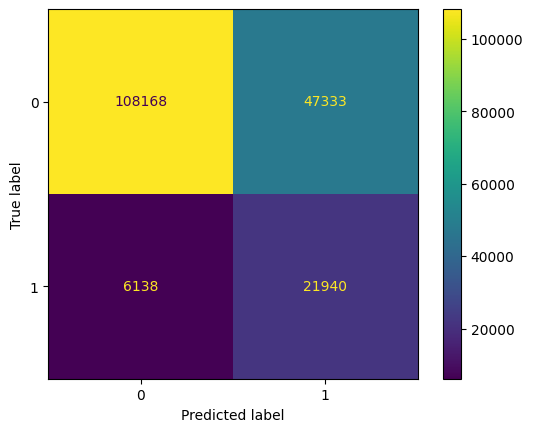

In [12]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(interaction_only=True, include_bias=False, degree=2)),
    ('var', VarianceThreshold(threshold=0.0)),
    ('svc', LinearSVC(
        class_weight='balanced',
        max_iter=10000,
        tol=0.0001,
        dual=False,
        C=0.1
    )),
])

_, best_lsvc_poly = model_evaluation(pipe, X_train, X_test, y_train, y_test)

## 3.3 Linear SVC with RBF Features

In [13]:
# 2 mins 25 secs

from sklearn.kernel_approximation import RBFSampler
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rbf', RBFSampler(random_state=42)),
    ('var', VarianceThreshold(threshold=0.0)),
    ('svc', LinearSVC(
        class_weight='balanced',
        max_iter=10000,
        tol=1e-3,
        dual=False
    )),
])

param = {
    'rbf__gamma': [0.01, 0.1, 1, 10, 100],
    'rbf__n_components': [256, 512],
    'svc__C': [0.01,0.1,1.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = HalvingGridSearchCV(
    estimator=pipe,
    param_grid=param,
    cv=cv,
    n_jobs=1,
    max_resources='auto',
    error_score='raise',
    scoring='balanced_accuracy'
)

grid.fit(X_train, y_train)

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    error_score='raise',
                    estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('rbf',
                                               RBFSampler(random_state=42)),
                                              ('var', VarianceThreshold()),
                                              ('svc',
                                               LinearSVC(class_weight='balanced',
                                                         dual=False,
                                                         max_iter=10000,
                                                         tol=0.001))]),
                    n_jobs=1,
                    param_grid={'rbf__gamma': [0.01, 0.1, 1, 10, 100],
                                'rbf__n_components': [256, 512],
                                'svc__C': [0.01, 0.1, 1.0]},
                    scoring='balanced_accuracy')

In [14]:
print(f"Best Parameters: {grid.best_params_}")
print(f"Best Score: {grid.best_score_}")

Best Parameters: {'rbf__gamma': 0.01, 'rbf__n_components': 512, 'svc__C': 0.1}
Best Score: 0.737327558425982


## 3.4 Train and Evaluate the Best LinearSVC with RBF Features Model

                      Train      Test
accuracy           0.710305  0.709010
balanced_accuracy  0.739825  0.741492
precision          0.850526  0.851513
recall             0.710305  0.709010
f1                 0.749426  0.748446
auc                0.739825  0.741492

Classification Report for Test Set:
               precision    recall  f1-score   support

           0       0.95      0.69      0.80     38876
           1       0.32      0.79      0.45      7019

    accuracy                           0.71     45895
   macro avg       0.63      0.74      0.63     45895
weighted avg       0.85      0.71      0.75     45895



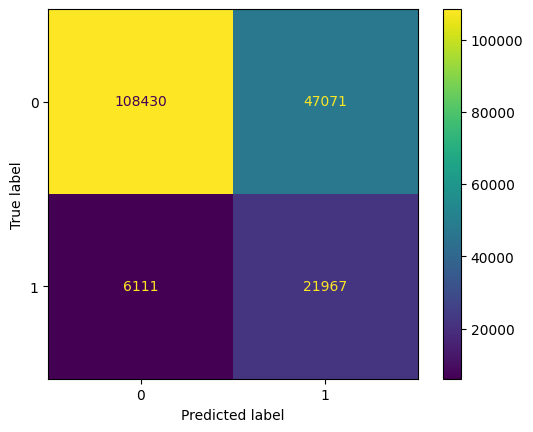

In [15]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rbf', RBFSampler(random_state=42, gamma=0.01, n_components=512)),
    ('var', VarianceThreshold(threshold=0.0)),
    ('svc', LinearSVC(
        class_weight='balanced',
        max_iter=10000,
        tol=0.0001,
        dual=False,
        C=0.1
    )),
])

_, best_lsvc_rbf = model_evaluation(pipe, X_train, X_test, y_train, y_test)

## 3.5 SGDClassifier (using hinge loss to mimic SVM) with RBF Features

In [16]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rbf', RBFSampler(random_state=42)),
    ('var', VarianceThreshold(threshold=0.0)),
    ('clf', SGDClassifier(
        loss='hinge',
        class_weight='balanced',
        max_iter=10000,
        tol=0.0001,
        early_stopping=True,
        n_jobs=1,
        n_iter_no_change=3
    ))
])

param = {
    'rbf__gamma': [0.01, 0.1, 1, 10, 100],
    'rbf__n_components': [256, 512],
    'clf__alpha': [0.0001, 0.001, 0.01]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = HalvingGridSearchCV(
    estimator=pipe,
    param_grid=param,
    cv=cv,
    n_jobs=1,
    max_resources='auto',
    error_score='raise',
    scoring='balanced_accuracy'
)

grid.fit(X_train, y_train)

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    error_score='raise',
                    estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('rbf',
                                               RBFSampler(random_state=42)),
                                              ('var', VarianceThreshold()),
                                              ('clf',
                                               SGDClassifier(class_weight='balanced',
                                                             early_stopping=True,
                                                             max_iter=10000,
                                                             n_iter_no_change=3,
                                                             n_jobs=1,
                                                             tol=0.0001))]),
                    n_jobs=1,
                    param_grid={'clf__alpha': [0.0001, 0.001, 0.01],
                                'rbf__gamma': [0.01, 0.1, 1, 10, 100],
                                'rbf__n_components': [256, 512]},
                    scoring='balanced_accuracy')

In [17]:
print(f"Best Parameters: {grid.best_params_}")
print(f"Best Score: {grid.best_score_}")

Best Parameters: {'clf__alpha': 0.001, 'rbf__gamma': 0.01, 'rbf__n_components': 512}
Best Score: 0.7324627287024311


                      Train      Test
accuracy           0.676199  0.673145
balanced_accuracy  0.732287  0.732931
precision          0.850666  0.851473
recall             0.676199  0.673145
f1                 0.721357  0.718805
auc                0.732287  0.732931

Classification Report for Test Set:
               precision    recall  f1-score   support

           0       0.95      0.65      0.77     38876
           1       0.30      0.82      0.43      7019

    accuracy                           0.67     45895
   macro avg       0.62      0.73      0.60     45895
weighted avg       0.85      0.67      0.72     45895



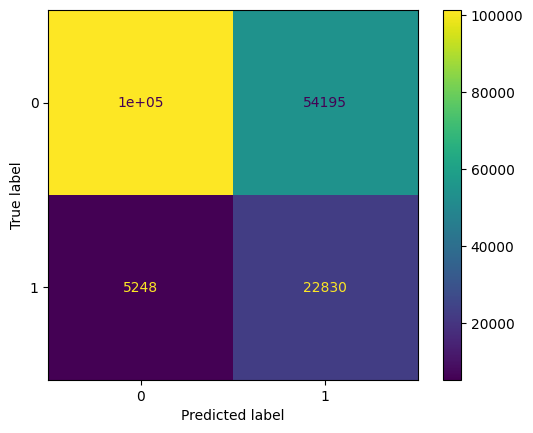

In [18]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rbf', RBFSampler(random_state=42, n_components=512, gamma=0.01)),
    ('clf', SGDClassifier(
        loss='hinge',
        class_weight='balanced',
        max_iter=10000,
        tol=0.0001,
        early_stopping=True,
        n_jobs=1,
        n_iter_no_change=3,
        alpha=0.001,
    ))
])

_, best_sgd_rbf = model_evaluation(pipe, X_train, X_test, y_train, y_test)

# 4 Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=1,
    random_state=42
)

param = {
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [50, 100, 200],
    'max_leaf_nodes': [50, 75, 100, 150]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = HalvingGridSearchCV(
    rf,
    param_grid=param,
    cv=cv,
    n_jobs=1,
    error_score='raise',
    max_resources='auto'
)

grid.fit(X_train, y_train)

HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    error_score='raise',
                    estimator=RandomForestClassifier(class_weight='balanced',
                                                     n_jobs=1,
                                                     random_state=42),
                    n_jobs=1,
                    param_grid={'max_depth': [5, 10, 20, 30],
                                'max_leaf_nodes': [50, 75, 100, 150],
                                'min_samples_split': [50, 100, 200]})

In [20]:
print(f"Best Parameters: {grid.best_params_}")
print(f"Best Score: {grid.best_score_}")

Best Parameters: {'max_depth': 10, 'max_leaf_nodes': 150, 'min_samples_split': 50}
Best Score: 0.710213375605345


                      Train      Test
accuracy           0.711628  0.709859
balanced_accuracy  0.739629  0.738725
precision          0.850299  0.850019
recall             0.711628  0.709859
f1                 0.750477  0.749036
auc                0.739629  0.738725

Classification Report for Test Set:
               precision    recall  f1-score   support

           0       0.95      0.70      0.80     38876
           1       0.32      0.78      0.45      7019

    accuracy                           0.71     45895
   macro avg       0.63      0.74      0.63     45895
weighted avg       0.85      0.71      0.75     45895



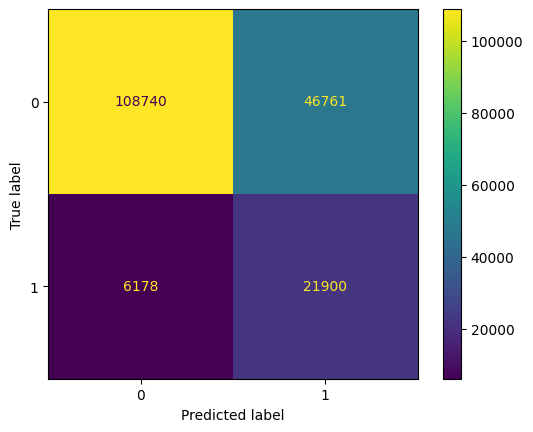

In [21]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=1,
    random_state=42,
    max_depth=10,
    max_leaf_nodes=150,
    min_samples_split=50
)

_, best_rf = model_evaluation(rf, X_train, X_test, y_train, y_test)

# 5 Results

In [23]:
import time
from IPython.display import display

y_true = np.ravel(y_test)

def _score_vector(m, X):
    """Return a continuous score for ROC/PR AUC: proba[:,1] if available else decision_function."""
    if hasattr(m, "predict_proba"):
        proba = m.predict_proba(X)
        if proba.ndim == 2 and proba.shape[1] >= 2:
            return proba[:, 1]
        return proba.ravel()
    if hasattr(m, "decision_function"):
        df = m.decision_function(X)
        return df[:, 1] if (hasattr(df, "ndim") and df.ndim == 2 and df.shape[1] >= 2) else df
    return m.predict(X)

def _safe(fn, *args, default=np.nan, **kwargs):
    try:
        return fn(*args, **kwargs)
    except Exception:
        return default

_expected = ["best_lsvc_poly", "best_lsvc_rbf", "best_sgd_rbf", "best_rf"]
_models = {name: globals()[name] for name in _expected if name in globals()}

rows = []
formatted_name = {
    "best_lsvc_poly": "LinearSVC + Poly Features",
    "best_lsvc_rbf": "LinearSVC + RBF Features",
    "best_sgd_rbf": "SGDClassifier + RBF Features",
    "best_rf": "Random Forest",
}
for name, model in _models.items():
    t0 = time.perf_counter()
    y_pred = model.predict(X_test)
    pred_time_ms = (time.perf_counter() - t0) * 1000.0

    y_score = _score_vector(model, X_test)

    row = {
        "model": formatted_name[name],
        "n_test": len(y_true),
        "pred_time_ms": pred_time_ms,
        "accuracy": _safe(accuracy_score, y_true, y_pred),
        "balanced_accuracy": _safe(balanced_accuracy_score, y_true, y_pred),
        "precision": _safe(precision_score, y_true, y_pred, zero_division=0),
        "recall": _safe(recall_score, y_true, y_pred, zero_division=0),
        "f1": _safe(f1_score, y_true, y_pred, zero_division=0),
        "roc_auc": _safe(roc_auc_score, y_true, y_score),
        "pr_auc": _safe(lambda yt, ys: pd.Series(ys).rolling(window=100, min_periods=1).mean().iloc[-1],
                        y_true, y_score)
    }
    rows.append(row)

df = pd.DataFrame(rows).set_index("model")

metric_cols = ["accuracy", "balanced_accuracy", "precision", "recall", "f1", "roc_auc", "pr_auc"]
fmt = {c: "{:.5f}" for c in metric_cols} | {"pred_time_ms": "{:.1f}"}

styled = (df.sort_values("roc_auc", ascending=False)
            .style.format(fmt)
            .set_caption("Test-set metrics by model")
            .highlight_max(subset=metric_cols, axis=0, color='red'))

display(styled)
df_sorted = df.sort_values("roc_auc", ascending=False)

,n_test,pred_time_ms,accuracy,balanced_accuracy,precision,recall,f1,roc_auc,pr_auc
model,,,,,,,,,
LinearSVC + RBF Features,45895,426.1,0.70901,0.74149,0.31795,0.78829,0.45313,0.81813,-0.14876
LinearSVC + Poly Features,45895,58.3,0.70589,0.73872,0.31502,0.78601,0.44978,0.81599,-0.14555
Random Forest,45895,283.7,0.70986,0.73873,0.31749,0.78031,0.45134,0.81418,0.44065
SGDClassifier + RBF Features,45895,319.5,0.67315,0.73293,0.29512,0.81906,0.43390,0.81047,-0.13498


In [24]:
df_sorted

,n_test,pred_time_ms,accuracy,balanced_accuracy,precision,recall,f1,roc_auc,pr_auc
model,,,,,,,,,
LinearSVC + RBF Features,45895,426.107667,0.709010,0.741492,0.317952,0.788289,0.453135,0.818127,-0.148757
LinearSVC + Poly Features,45895,58.325708,0.705894,0.738719,0.315023,0.786009,0.449780,0.815995,-0.145547
Random Forest,45895,283.742250,0.709859,0.738725,0.317489,0.780311,0.451339,0.814177,0.440647
SGDClassifier + RBF Features,45895,319.515041,0.673145,0.732931,0.295123,0.819063,0.433903,0.810473,-0.134981
